# citysong

an agent-based approach to modeling urban birdsong

#### import statements

In [1]:
import numpy
from matplotlib import pyplot
from scipy.ndimage import uniform_filter

In [2]:
from math import sqrt, ceil

In [3]:
from numba import jit, guvectorize, int64, float64

#### variable declarations

In [4]:
width = 100
height = 100

In [5]:
seconds = 1000

In [6]:
n_trees = 10
n_birds = 10

In [7]:
cmp = numpy.zeros((width, height), dtype=numpy.int64)
trees = numpy.zeros((width, height), dtype=numpy.int64)
index = numpy.arange(0, width * height, dtype=numpy.int64)

#### create maps

In [8]:
index_coords = numpy.zeros((width * height, 2), dtype=numpy.int64)

In [9]:
x = 0
for r in range(height):
    for c in range(width):
        index_coords[x] = [r, c]
        x = x + 1

In [10]:
tree_x_coords = numpy.random.randint(low=0, high=width, size=n_trees)
tree_y_coords = numpy.random.randint(low=0, high=height, size=n_trees)
tree_coords_index = numpy.arange(n_trees, dtype=int)
for tree in range(n_trees):
    trees[tree_y_coords[tree], tree_x_coords[tree]] = 1

In [11]:
suitability = uniform_filter(trees.astype(numpy.float64), size=5)
suitability = suitability + abs(suitability.min())
suitability_sort = numpy.copy(suitability.ravel())
suitability_sort = suitability_sort/suitability_sort.sum()

## bird

0 -> column (x position) <br />
1 -> row (y position) <br />
2 -> moving (0 or 1) <br />
3 -> move complete (0-1) <br />
4 -> column (x start) <br />
5 -> row (y start) <br />
6 -> column (x destination) <br />
7 -> row (y destination) <br />
8 -> move distance

#### create birds

In [12]:
birds = numpy.zeros((n_birds, 9), dtype=numpy.int64)
for idx, b in enumerate(birds):
    i = numpy.random.choice(tree_coords_index)
    birds[idx][0] = tree_x_coords[i]
    birds[idx][1] = tree_y_coords[i]
    birds[idx][2] = 0
    birds[idx][3] = 0
    birds[idx][4] = 0
    birds[idx][5] = 0
    birds[idx][6] = 0
    birds[idx][7] = 0
    birds[idx][8] = 0

## plot habitat

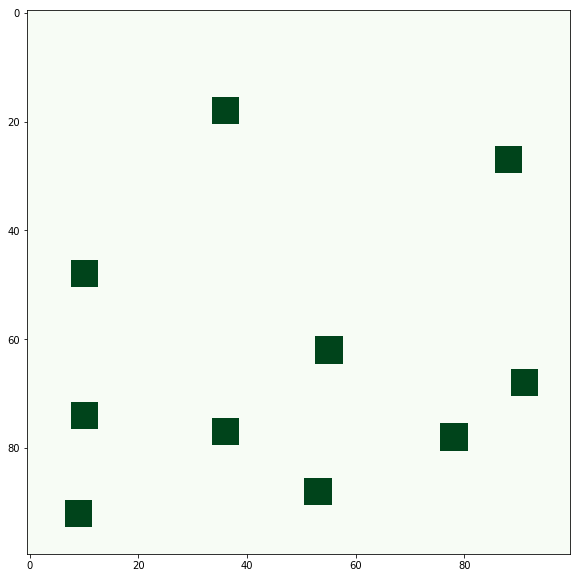

In [13]:
figure, ax = pyplot.subplots()
figure.set_figheight(10)
figure.set_figwidth(10)

ax.imshow(suitability, cmap="Greens")

## run simulation

In [14]:
samples = numpy.random.choice(index, size=(seconds, n_birds), p=suitability_sort)

In [15]:
def run_guvectorize(grid, seconds, n_birds, birds, index, samples, index_coords, cmp):
    for s in range(seconds):
        for idx in range(n_birds):
            b = birds[idx]
            # check if bird is moving
            if b[2]:
                b[3] = b[3] + 1
                p = float(b[3]) / float(b[8])
                # calculate coords and update bird's position
                b[0] = int(ceil((b[6] - b[4]) * p) + b[4])# + numpy.random.randint(-5, 6)
                b[1] = int(ceil((b[7] - b[5]) * p) + b[5])# + numpy.random.randint(-5, 6)
                # check if bird reached destination
                if b[0] == b[6] and b[1] == b[7]:
                    b[2] = 0
                    b[3] = 0
                    b[4] = 0
                    b[5] = 0
                    b[6] = 0
                    b[7] = 0
                    b[8] = 0
            # bird is not moving
            else:
                # possibly set bird in motion
                move = numpy.random.randint(0, 100)
                if move < 20:
                # count number of nearby birds:
                    #count = ((birds[:, 0] > (b[0] - 10))*(birds[:, 0] < (b[0] + 10))*(birds[:, 1] > (b[1] - 10))*(birds[:, 1]< (b[1] + 10))).sum()
                    #if count < 1 or count > 5:
                        # set bird is moving
                        b[2] = 1
                        # save start destination
                        b[4] = b[0]
                        b[5] = b[1]
                        # set new destination
                        b[6] = index_coords[samples[s, idx]][0]
                        b[7] = index_coords[samples[s, idx]][1]
                        # set distance of move
                        b[8] = ceil(sqrt((b[6]-b[4])**2 + (b[7]-b[5])**2))
            # check for possible bird call
            call = numpy.random.randint(0, 100)
            if call < 5:
                # check if bird is near other birds
                # count number of nearby birds:
                #count = ((birds[:, 0] > (b[0] - 10))*(birds[:, 0] < (b[0] + 10))*(birds[:, 1] > (b[1] - 10))*(birds[:, 1]< (b[1] + 10))).sum()
                #if count < 2:
                cmp[b[0], b[1]] = cmp[b[0], b[1]] + 1

In [16]:
run_numba = guvectorize('int64[:,:], int64, int64, int64[:,:], int64[:], int64[:,:], int64[:,:], int64[:,:]', '(w,h),(),(),(b,a),(n),(s,b),(n,c)->(w,h)', target='parallel', nopython=True)(run_guvectorize)

In [17]:
cmp = run_numba(cmp, seconds, n_birds, birds, index, samples, index_coords, cmp)

## plot bird calls

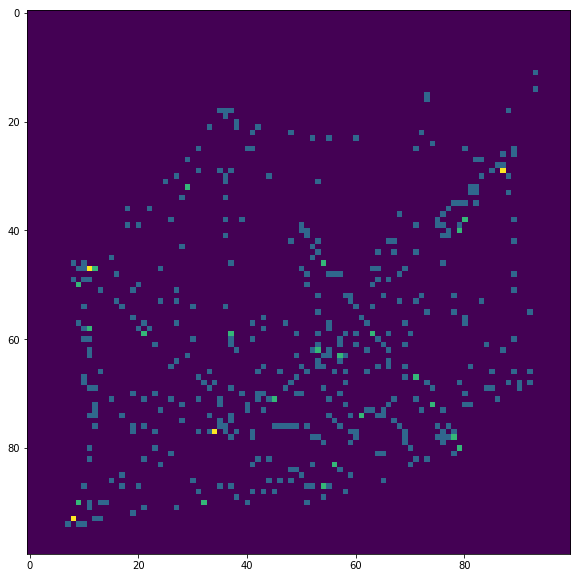

In [18]:
figure, ax = pyplot.subplots()
figure.set_figheight(10)
figure.set_figwidth(10)

ax.imshow(cmp, cmap="viridis")

#### create sound attenuation mask

In [25]:
call_mask = numpy.zeros(shape=(101, 101))

In [26]:
for c in range(101):
    for r in range(101):
        dist = sqrt((50-c)**2 + (50-r)**2)
        if dist <= 50:
            try:
                call_mask[r, c] = 1
            except ZeroDivisionError:
                call_mask[r, c] = 1

In [27]:
cmp_2 = numpy.zeros(shape=(height+100, width+100))

In [28]:
def call():
    for c in range(50, width+50):
        for r in range(50, height+50):
            value = cmp[r-50, c-50]
            if value > 0:
                cmp_2[r-50:r+51, c-50:c+51] = cmp_2[r-50:r+51, c-50:c+51] + call_mask * value

In [29]:
call()

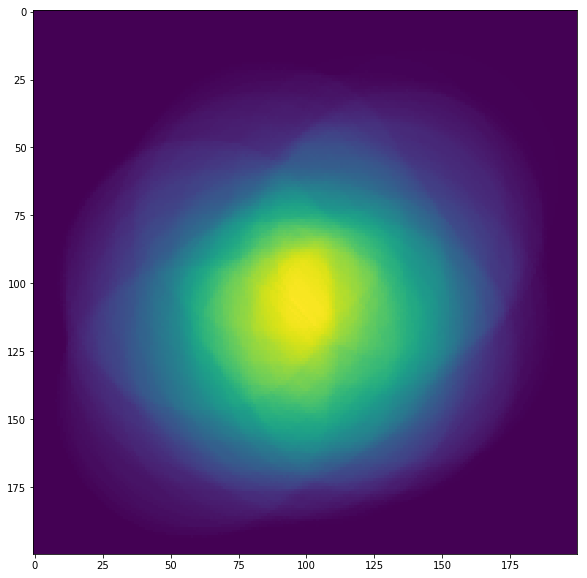

In [30]:
figure, ax = pyplot.subplots()
figure.set_figheight(10)
figure.set_figwidth(10)

ax.imshow(cmp_2, cmap="viridis")